<a href="https://colab.research.google.com/github/saint1729/cs6140_final_project/blob/saint1729/CS6140_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Files already downloaded and verified
cuda:0
epoch:  0  batch:    0 [     0/50000]  loss: 10.12628651 time taken = 0.4987819194793701
epoch:  1  batch:    0 [     0/50000]  loss: 15.75214100 time taken = 1.3031682968139648
epoch:  2  batch:    0 [     0/50000]  loss: 11.35111332 time taken = 2.102781057357788
epoch:  3  batch:    0 [     0/50000]  loss: 8.83598042 time taken = 2.9001104831695557
epoch:  4  batch:    0 [     0/50000]  loss: 6.62132168 time taken = 3.678231716156006
epoch:  5  batch:    0 [     0/50000]  loss: 1.81964290 time taken = 4.481229305267334
epoch:  6  batch:    0 [     0/50000]  loss: 2.29176211 time taken = 5.265593767166138
epoch:  7  batch:    0 [     0/50000]  loss: 1.43670249 time taken = 6.065838098526001
epoch:  8  batch:    0 [     0/50000]  loss: 6.62493420 time taken = 6.862664699554443
epoch:  9  batch:    0 [     0/50000]  loss: 8.92840576 time taken = 7.6720874309539795
epoch: 10  batch:    0 [     0/50000]  loss: 8.54402161 time taken = 8.4698376

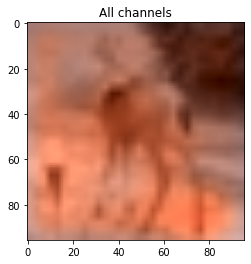

In [3]:
import time

import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

import lab_distribution
from plot import imshow_torch, plot_image_channels
from network import Net
from custom_transforms import RGB2LAB, ToTensor

import cv2

%matplotlib inline


ab_bins_dict = np.load("./resources/prior_lab_distribution_train.npz", allow_pickle=True)
ab_bins, a_bins, b_bins = ab_bins_dict['ab_bins'], ab_bins_dict['a_bins'], ab_bins_dict['b_bins']

transform = transforms.Compose([transforms.Resize((96, 96)), RGB2LAB(ab_bins), ToTensor()])
trainset = torchvision.datasets.ImageFolder(root='./data/custom/train/', transform=transform)
# testset = torchvision.datasets.ImageFolder('./data/custom/test/', transform=transform)

# trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=0)

cnn = Net(ab_bins_dict)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
cnn = cnn.to(device)

cnn.set_rarity_weights(ab_bins_dict['w_bins'])
criterion = cnn.loss
optimizer = optim.Adam(cnn.parameters(), weight_decay=.001)

index = 0
start_time = time.time()
for epoch in range(20):
    for i, data in enumerate(trainloader):
        inputs, labels = data
        lightness, z_truth, original = inputs['lightness'].to(device), inputs['z_truth'].to(device), inputs['original_lab_image'].to(device)

        optimizer.zero_grad()
        outputs = cnn(lightness)
        ab_outputs = cnn.decode_ab_values()

        colorized_im = torch.cat((lightness, ab_outputs), 1)
        #    plot_image_channels(colorized_im.detach()[0, :, :, :], figure=20)
        loss = criterion(z_truth)
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print(f"epoch: {epoch:2}  batch: {i:4} [{10*i:6}/50000]  loss: {loss.item():10.8f} time taken = {time.time() - start_time}")
            if i == 1000:
                break

    # if epoch % 50 == 0:
    #     print(f"Epoch = {epoch:4}, loss = {loss.item():10.8f}, time taken = {time.time() - start_time}")


with torch.no_grad():
    for b, (X_test, y_test) in enumerate(testloader):
        lightness, z_truth, original = X_test['lightness'].to(device), X_test['z_truth'].to(device), X_test['original_lab_image'].to(device)
        outputs = cnn(lightness)
        ab_outputs = cnn.decode_ab_values()
        # print(ab_outputs)
        color_img = torch.cat((lightness, ab_outputs), 1)
        image_np_lab = np.transpose(color_img.cpu().detach()[0, :, :, :].numpy(), (1, 2, 0))
        image_np_rgb_all = cv2.cvtColor(image_np_lab, cv2.COLOR_LAB2RGB)
        # print(image_np_rgb_all)
        plt.imsave("./drive/MyDrive/cs6140/project/output/" + str(b + 1) + ".jpg", image_np_rgb_all)
        plt.imshow(image_np_rgb_all)
        plt.title('All channels')
        if b == 100:
            break

plt.show()
